In [2]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab Notebooks/'       # path to your project on Drive



drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)


Mounted at /content/drive


In [ ]:
GIT_USERNAME = "ahhuang007" # replace with yours
GIT_TOKEN = os.environ['git_key_wsb']           # definitely replace with yours
GIT_REPOSITORY = "wallstreetbets"      # ...nah


In [ ]:
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"

In [3]:
%cd drive/My Drive/Colab Notebooks/wallstreetbets

/content/drive/My Drive/Colab Notebooks/wallstreetbets


Pulling data from Github

In [30]:
!git pull origin

error: You have not concluded your merge (MERGE_HEAD exists).
hint: Please, commit your changes before merging.
fatal: Exiting because of unfinished merge.


Pushing updates to Github

In [36]:
!git add .

In [37]:
!git config --global user.email "ahhuang007@gmail.com"
!git config --global user.name "ahhuang007"

In [38]:
!git commit -m "finished setting up validation simulation, 'only' lost like $9, which I guess is progress"

[main 9d7692f] finished setting up validation simulation, 'only' lost like 9, which I guess is progress
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite colab_ml_testing.ipynb (96%)


In [34]:
!git remote set-url origin https://$git_key_wsb@github.com/ahhuang007/wallstreetbets.git

In [39]:
!git push origin

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 61.34 KiB | 7.67 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/ahhuang007/wallstreetbets.git
   4d07510..9d7692f  main -> main


First approach - SGDRegressor

In [4]:
import pandas as pd

In [5]:
#Gathering data, formatting it for training/testing
from sklearn.preprocessing import MinMaxScaler

dfs = []
training_datas = []
cryptos = ['AAVE', 'ADA', 'ALGO', 'ATOM', 
           'AVAX', 'BCH', 'BTC', 'DOT', 
           'ETH', 'LINK', 'LRC', 'LTC', 
           'MANA', 'MATIC', 'SOL', 'UNI']
cryptos = ['BTC']
for c in cryptos:
    df = pd.read_csv('./data/' + c + '_data.csv')
    '''I think we'll do a similar plan to my source idea.
    5 months for training, 2 months for validation/tuning, 5 months for testing
    '''
    #dfs.append(df[38:175200].reset_index(drop = True))
    #Splitting data into training/validation/test
    
    df = df.drop(['timestamp', 'Unnamed: 0'], axis = 1)
    cols = df.columns
    df = df[38:]

    #Normalizing data
    scaler = MinMaxScaler()
    df = pd.DataFrame(data = scaler.fit_transform(df))
    df.columns = cols
    labels = df['close'][1:].reset_index(drop = True)
    training = (df[:175200].reset_index(drop = True), labels[:175200].reset_index(drop = True))
    validation = (df[175200:282600].reset_index(drop = True), labels[175200:282600].reset_index(drop = True))
    testing = (df[262800:-1].reset_index(drop = True), labels[262800:].reset_index(drop = True))
    training_datas.append([training, validation, testing])

In [6]:
#Import ML stuff, create gridsearch and fit
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

X_train = training_datas[0][0][0]
y_train = training_datas[0][0][1]
X_val = training_datas[0][1][0]
y_val = training_datas[0][1][1]
'''
param_grid = {'loss':('squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
              }
'''

sgdreg = SGDRegressor(max_iter = 1000, tol = 1e-4)
sgdreg.fit(X_train.values, y_train.values)

SGDRegressor(tol=0.0001)

In [7]:
sgdreg.score(X_val.values, y_val.values)

0.9999194244016334

In [8]:
preds = sgdreg.predict(X_val.values)

In [9]:
preds

array([0.69189601, 0.69295936, 0.69317441, ..., 0.08989008, 0.08981726,
       0.08976889])

In [10]:
y_val

0         0.692990
1         0.693212
2         0.693435
3         0.693238
4         0.695084
            ...   
107395    0.089620
107396    0.089705
107397    0.089741
107398    0.089532
107399    0.089159
Name: close, Length: 107400, dtype: float64

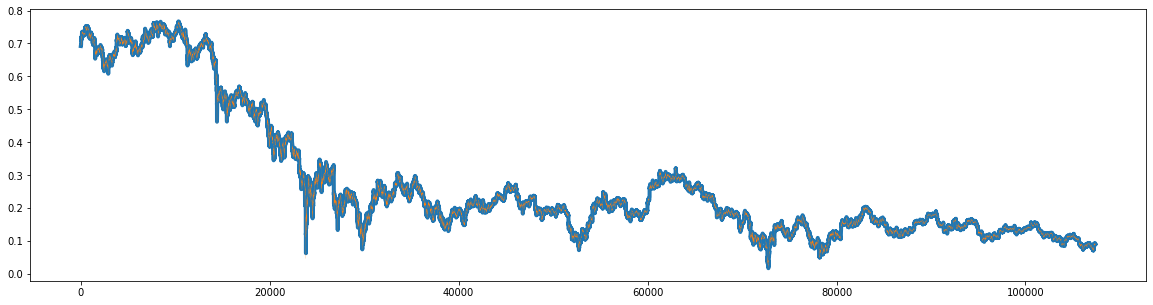

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
plt.plot(preds, alpha = 1, linewidth = 4)
plt.plot(y_val, alpha = 1, linewidth = 0.1)
plt.show()

In [12]:
#naive approach - all-in trades with no fees
def sell_low(balance, shares, close):
    if shares > 0:
        #update balance
        balance += shares * close
        shares = 0
    else:
        pass #No shares to sell!
    return balance, shares

def buy_high(balance, shares, close):
    if balance > 0:
        #update balance
        shares += (balance / close)
        balance = 0
        
    else:
        pass
    return balance, shares

In [13]:
#Attempting simulation on validation data
import numpy as np

balance = 100
shares = 0
counter = 175200
orig_df = pd.read_csv('./data/BTC_data.csv')[175199:]
total = []
cur = orig_df.loc[175199, "close"]
for i in range(len(y_val)):
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, total[-1]))
    pred = sgdreg.predict(np.array(X_val.loc[i,:]).reshape(1, 8))
    cur_norm = X_val.loc[i, 'close']
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

Timestep 180000: Balance is 101.79692286731651, shares is 0, total is 101.79692286731651
Timestep 190000: Balance is 0, shares is 0.001901075845942282, total is 96.83175447127316
Timestep 200000: Balance is 70.52338174183622, shares is 0, total is 70.52338174183622
Timestep 210000: Balance is 0, shares is 0.0017170990882685669, total is 64.27012598236657
Timestep 220000: Balance is 0, shares is 0.0017903374718966987, total is 66.88607697457529
Timestep 230000: Balance is 0, shares is 0.002099957557823371, total is 78.16018930685452
Timestep 240000: Balance is 0, shares is 0.00214862443605602, total is 82.39761998455667
Timestep 250000: Balance is 80.81251813145042, shares is 0, total is 80.81251813145042
Timestep 260000: Balance is 0, shares is 0.0025648792087056772, total is 89.78813653694164
Timestep 270000: Balance is 96.79868384623097, shares is 0, total is 96.79868384623097
Timestep 280000: Balance is 0, shares is 0.0028854356503536095, total is 94.32520880798104


I mean, all in all not terrible given it's a bear market and our previous best is like $40. So, not bad!

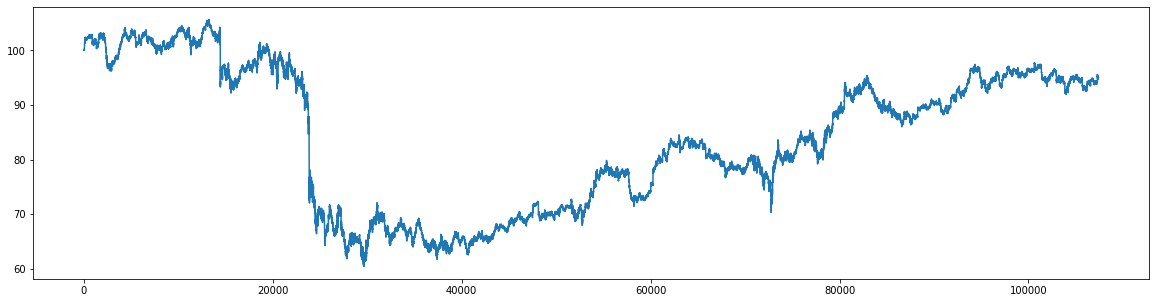

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(total)
plt.show()

In [16]:
#Testing portion using final 5 months of data
import numpy as np

X_test = training_datas[0][2][0]
y_test = training_datas[0][2][1]
balance = 100
shares = 0
counter = 262800
orig_df = pd.read_csv('./data/BTC_data.csv')[262799:]
test_total = []
cur = orig_df.loc[262799, "close"]
for i in range(len(y_test)):
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, test_total[-1]))
    pred = sgdreg.predict(np.array(X_test.loc[i, :]).reshape(1,8))
    cur_norm = X_test.loc[i, 'close']
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    test_total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

Timestep 270000: Balance is 111.71368642224988, shares is 0, total is 111.71368642224988
Timestep 280000: Balance is 0, shares is 0.003330031366410294, total is 108.85909167140281
Timestep 290000: Balance is 0, shares is 0.003542123912391769, total is 114.39909046753885
Timestep 300000: Balance is 0, shares is 0.0033778258962553352, total is 135.51790206213857
Timestep 310000: Balance is 136.6863049437327, shares is 0, total is 136.6863049437327
Timestep 320000: Balance is 0, shares is 0.0035603861998126296, total is 165.3334047336651
Timestep 330000: Balance is 0, shares is 0.0035314263182730514, total is 159.9969902599962
Timestep 340000: Balance is 0, shares is 0.003512581761145063, total is 167.6691562766871
Timestep 350000: Balance is 170.974260250001, shares is 0, total is 170.974260250001
Timestep 360000: Balance is 165.2496151192707, shares is 0, total is 165.2496151192707
Timestep 370000: Balance is 169.4683508149772, shares is 0, total is 169.4683508149772
Timestep 380000: Ba

Pretty good, but everything looks good in a bull market I guess.

But hang on a second, after checking it looks like we actually beat the bear market as well at the end of the year, so good job me.

In [17]:
test_total[-1]

184.7198109733496

Other possible approaches - SGDClassifier to test just increasing/decreasing classification, GridSearchCV on various methods, ensemble methods